# Setup

In [1]:
# %%
import warnings
from folding.utils.ops import check_and_download_pdbs, check_if_directory_exists
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import sys
import requests
import os
import math
from pprint import pprint
from Bio.PDB import PDBParser
import concurrent.futures
import random

random.seed(163)


warnings.filterwarnings("ignore")

In [2]:
COMPLETE_IDs_FILE = "./pdb_ids_complete.pkl"
INCOMPLETE_IDs_FILE = "./pdb_ids_incomplete.pkl"
NOT_DOWNLOADABLE_IDs_FILE = "./pdb_ids_not_downloadable.pkl"

COMPLETE_PDB_FILES = "./complete_pdbs/"
INCOMPLETE_PDB_FILES = "./incomplete_pdbs/"


def analyze_pdb_batch(pdb_ids: dict, pdb_directory: str, delete_pdb: bool = False):
    """
    Analyzes a batch of PDB ids (as returned by scripts/gather_pdbs.py and scripts/classify_pdbs.py) and returns a pandas DataFrame with the number of atoms in each PDB file.

    Args:
        pdb_ids (dict): A dictionary containing the PDB IDs lists.
        pdb_directory (str): The directory where the PDB files will be downloaded and stored.
        delete_pdb (bool, optional): Whether to delete the downloaded PDB files after analysis. Defaults to False.

    Returns:
        pandas.DataFrame: A DataFrame with the number of atoms in each PDB file, indexed by the PDB IDs.

    """
    # Creating empty pandas dataframe
    data_dict = defaultdict()

    def analyze_pdb(pdb_id: str):
        nonlocal data_dict, delete_pdb, pdb_directory
        # Downloading the PDB file
        download_pdb(pdb_directory, pdb_id=pdb_id + ".pdb")
        parser = PDBParser()

        structure = parser.get_structure(
            pdb_id, f"{pdb_directory}{pdb_id}.pdb")

        # Get all atoms
        atoms = [atom for atom in structure.get_atoms()]

        # The number of atoms in the molecule
        num_atoms = len(atoms)

        if delete_pdb:
            # Deleting the pdb file
            os.remove(f"{pdb_directory}{pdb_id}.pdb")

        data_dict[pdb_id] = num_atoms

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(analyze_pdb, pdb_id)
            for v in pdb_ids.values()
            for pdb_id in v
        ]
        concurrent.futures.wait(futures)

    # Creating dataframe from data_dict
    df = pd.DataFrame.from_dict(
        data_dict, orient="index", columns=["Number of Atoms"])

    return df


def download_pdb(pdb_directory: str, pdb_id: str) -> bool:
    """
    Downloads a PDB file from the RCSB PDB database.

    Args:
        pdb_directory (str): The directory where the PDB file will be saved.
        pdb_id (str): The PDB ID of the file to be downloaded.

    Returns:
        bool: True if the file was downloaded successfully, False otherwise.
    """

    url = f"https://files.rcsb.org/download/{pdb_id}"
    path = os.path.join(pdb_directory, f"{pdb_id}")

    r = requests.get(url)
    if r.status_code == 200:

        check_if_directory_exists(output_directory=pdb_directory)
        with open(path, "w") as file:
            file.write(r.text)

        return True
    else:
        return False

# Exploring complete pdbs

In [3]:
# with open(COMPLETE_IDs_FILE, "rb") as f:
#     complete_pdb_ids = pkl.load(f)

# # Testing the function
# mini_batch = {k: complete_pdb_ids[k] for k in list(complete_pdb_ids)[:2]}

In [4]:
# df = analyze_pdb_batch(complete_pdb_ids, delete_pdb=False)
# df.to_csv("complete_pdbs_analysis.csv")

# Exploring incomplete pdbs

In [5]:
# with open(INCOMPLETE_IDs_FILE, "rb") as f:
#     incomplete_pdb_ids = pkl.load(f)


# # Sampling 20%
# sampled_ids = defaultdict(list)
# for k, v in incomplete_pdb_ids.items():
#     sampled_ids[k] = np.random.choice(v, math.ceil(len(v) * 0.2), replace=False)

# # Total number of samples
# total_samples = sum([len(v) for k, v in sampled_ids.items()])
# print(f"Total number of samples: {total_samples}")

In [6]:
# # Analyzing
# df_incomplete = analyze_pdb_batch(
#     sampled_ids, pdb_directory=INCOMPLETE_PDB_FILES, delete_pdb=True
# )
# df_incomplete.to_csv("incomplete_pdbs_20p_analysis.csv")

# Comparing

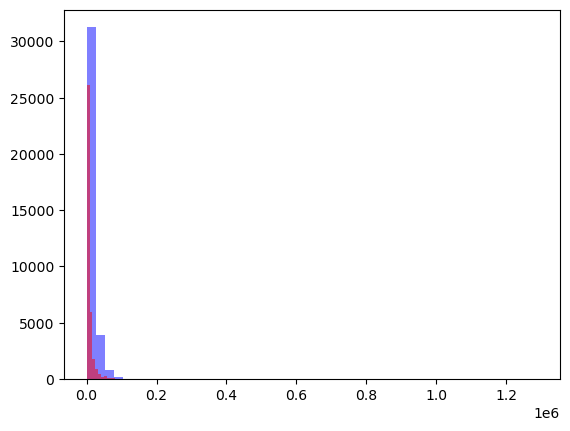

In [7]:
df_complete = pd.read_csv("complete_pdbs_analysis.csv")
df_incomplete = pd.read_csv("incomplete_pdbs_20p_analysis.csv")  # 20%
# df_incomplete = pd.read_csv("incomplete_pdbs_5p_analysis.csv") #5%

# Histogram comparing both complete and incomplete pdbs, complete in blue, incomplete in red
fig, ax = plt.subplots()
ax.hist(df_complete["Number of Atoms"], bins=50, color="blue", alpha=0.5)
ax.hist(df_incomplete["Number of Atoms"], bins=50, color="red", alpha=0.5)
plt.show()

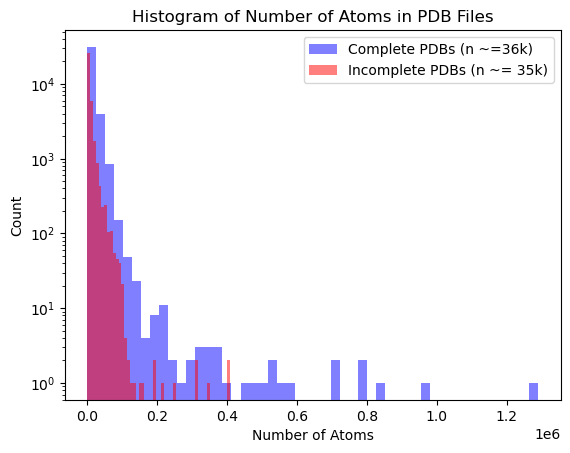

In [8]:
# Histograms in log scale
fig, ax = plt.subplots()
ax.hist(df_complete["Number of Atoms"], bins=50, color="blue", alpha=0.5)
ax.hist(df_incomplete["Number of Atoms"], bins=50, color="red", alpha=0.5)
ax.set_yscale("log")

# Adding labels
plt.xlabel("Number of Atoms")
plt.ylabel("Count")
plt.title("Histogram of Number of Atoms in PDB Files")
plt.legend(["Complete PDBs (n ~=36k)", "Incomplete PDBs (n ~= 35k)"])

plt.show()

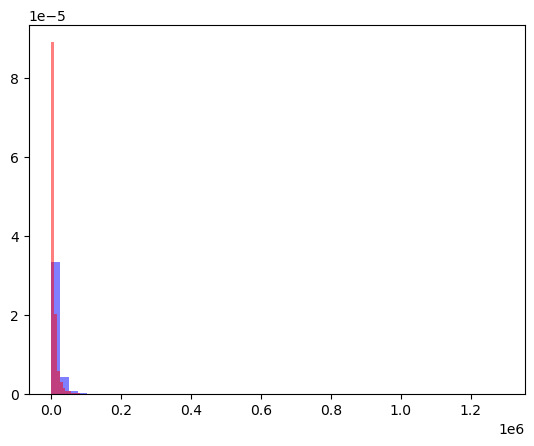

In [9]:
# Normalized histograms
fig, ax = plt.subplots()
ax.hist(df_complete["Number of Atoms"], bins=50,
        color="blue", alpha=0.5, density=True)
ax.hist(df_incomplete["Number of Atoms"], bins=50,
        color="red", alpha=0.5, density=True)
plt.show()